# Introduction
We will produce a 5 percent Value-at-Risk (VaR) estimate for the S&P500. We assume the variance of returns follows a $GARCH(1, 1)$ model. The orders of the GARCH model will not be fit to the data; we refer the reader to the literature which states $GARCH(1, 1)$ models tend to perform best out-of-sample for financial data. 

We suppose the return at time $t$ of the S&P500
$$
r_t \sim{\mathcal{N}(0, \sigma_t^2)}
$$
where
$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma_{t-1}^2.
$$
This implies
$$
VaR_t\approx 1.645\sigma_t.
$$

The date range for this exercise is 2008 to 2020, inclusive, and the data are at the daily frequency. We choose this range because it includes the financial crisis and the market downturn in March of 2020. We will see that slightly more than 5 percent of days of each year are exceptions. This seems reasonable even given a long-term fraction of exceptions each year is 5 percent because of the time-window we are considering. We obtained our data from Yahoo Finance.

# Packages and Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')


To calculate returns, we will use the adjusted closing price of the SP&P500 because we do not want a VaR exceptions to be triggered due to changes in the index, dividend payments, or a stock splits. 

In [2]:
# Load S&P500 data
sp500 = pd.read_csv("sp500.csv")

# Convert data column to date object
sp500['Date'] = pd.to_datetime(sp500['Date'], format = '%Y-%m-%d')

# Calculate returns
sp500['Ret'] = (sp500['Adj Close'] - sp500['Adj Close'].shift(1))/sp500['Adj Close'].shift(1)

# Only use the two most informative columns
sp500 = sp500[['Date', 'Ret']]

# Fill missing values with 0
sp500['Ret'] = sp500['Ret'].fillna(0)

# Only consider observations from the year 2008 to 2020, inclusive
sp500 = sp500.loc[(sp500['Date'].dt.year >= 2008) & (sp500['Date'].dt.year < 2021), :].reset_index(drop = True)

sp500.head()

,Date,Ret,year
0,2008-01-02,-0.014438,2008
1,2008-01-03,0.000000,2008
2,2008-01-04,-0.024552,2008
3,2008-01-07,0.003223,2008
4,2008-01-08,-0.018352,2008


To obtain the parameters $\omega$, $\alpha$, and $\beta$ in the model
$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta\sigma_{t-1}^2
$$
we will use MLE parameters of data from time $t - 126$ to $t - 1$. Since our optimizer minimizes, we will negate the output of the likelihood function. We define our likelihood function so that 
$$
\alpha + \beta < 1\quad\text{and}\quad \omega, \alpha, \beta \geq 0.
$$

In [3]:
def likelihood(x, date):
    
    # Initialize likelihood
    likelihood = 0
    
    # Need the sum of alpha and beta to be less than 1 and all terms to be positive
    if (np.sum(x[1:]) > 1) | (np.min(x) < 0) :
           
            return np.Inf
            
    else:
        
        # Calculate observation range
        stop = np.sum(sp500['Date'] < date)
        
        # Consider observations 126 days before; expanding window when not enough observations
        start = np.max([stop - 126, 0])
        
        # Initialize sigma^2
        sigma2 = sp500.loc[start, 'Ret']**2 
    
        # Initialize epsilon^2
        epsilon2 = sp500.loc[start, 'Ret']**2 
        
        # Start is included and stop is excluded in Python
        for i in range(start, stop):
    
            sigma2 = x[0] + x[1] * epsilon2 + x[2] * sigma2
        
            epsilon2 = sp500.loc[i, 'Ret']**2 
        
            # Multiply likelihood value by pdf evaluate at new value and parameter
            likelihood *= stats.norm.pdf(np.sqrt(epsilon2), loc = 0, scale = np.sqrt(sigma2))
     
        # Negative because optimizer minimizes
        return -likelihood


Since we assume $r_t\sim{\mathcal{N}(0, \sigma_t)}$, at the time $t$ the 5 percent Value-at-Risk
$$
VaR_t = \Phi^{-1}(0.05)\cdot \sigma_t,
$$
where $\Phi$ is the CDF of the standard normal distribution.

In [4]:
# Initialize sigma^2 for first day
sigma2 = 2 * 10**-5

# Initialize VaR column
sp500['VaR'] = 0

# Calculate VaR for first day
sp500.loc[0, 'VaR'] = np.sqrt(sigma2)

# Initilize optimizer; after first iteration the previous iteration value will be used for initialization 
x = [2 * 10**-5 , 0.40, 0.40]

for i in sp500.index[1:]:
    
    x = opt.minimize(lambda x: likelihood(x, sp500.loc[i, 'Date']), x0 = x, method = 'Nelder-Mead')['x']
    
    sigma2 = x[0] + x[1] * sp500.loc[i - 1, 'Ret']**2 + x[2] * sigma2
    
    # Get sd for VaR calculation; true VaR will be computed later
    sp500.loc[i, 'VaR'] = np.sqrt(sigma2)

# Z is about -1.645
Z = stats.norm.ppf(0.05)

# Multiple by -Z to obtain VaR
sp500['VaR'] = 0 - Z * sp500['VaR']

# Obtain days when there is an exception
sp500['Exception'] = 0 - sp500['VaR'] > sp500['Ret']


The fraction of days which are exceptions is about 6.7 percent. This is larger than our target of 5 percent. However, our time range includes two extraordinarily larg downturns. As a result, if only 5 percent of days were exceptions, then it may imply our Value-at-Risk calculation is too conservative and the long-term fraction of exceptions is--in fact--less than 5 percent.

In [12]:
sp500['Frac_Excp'] = sp500.groupby(sp500['Date'].dt.year)['exception'].transform('mean')

sp500['Frac_Excp'].describe()

count    3274.000000
mean        0.065669
std         0.029244
min         0.015936
25%         0.047619
50%         0.067460
75%         0.083004
max         0.130435
Name: Frac_Excp, dtype: float64

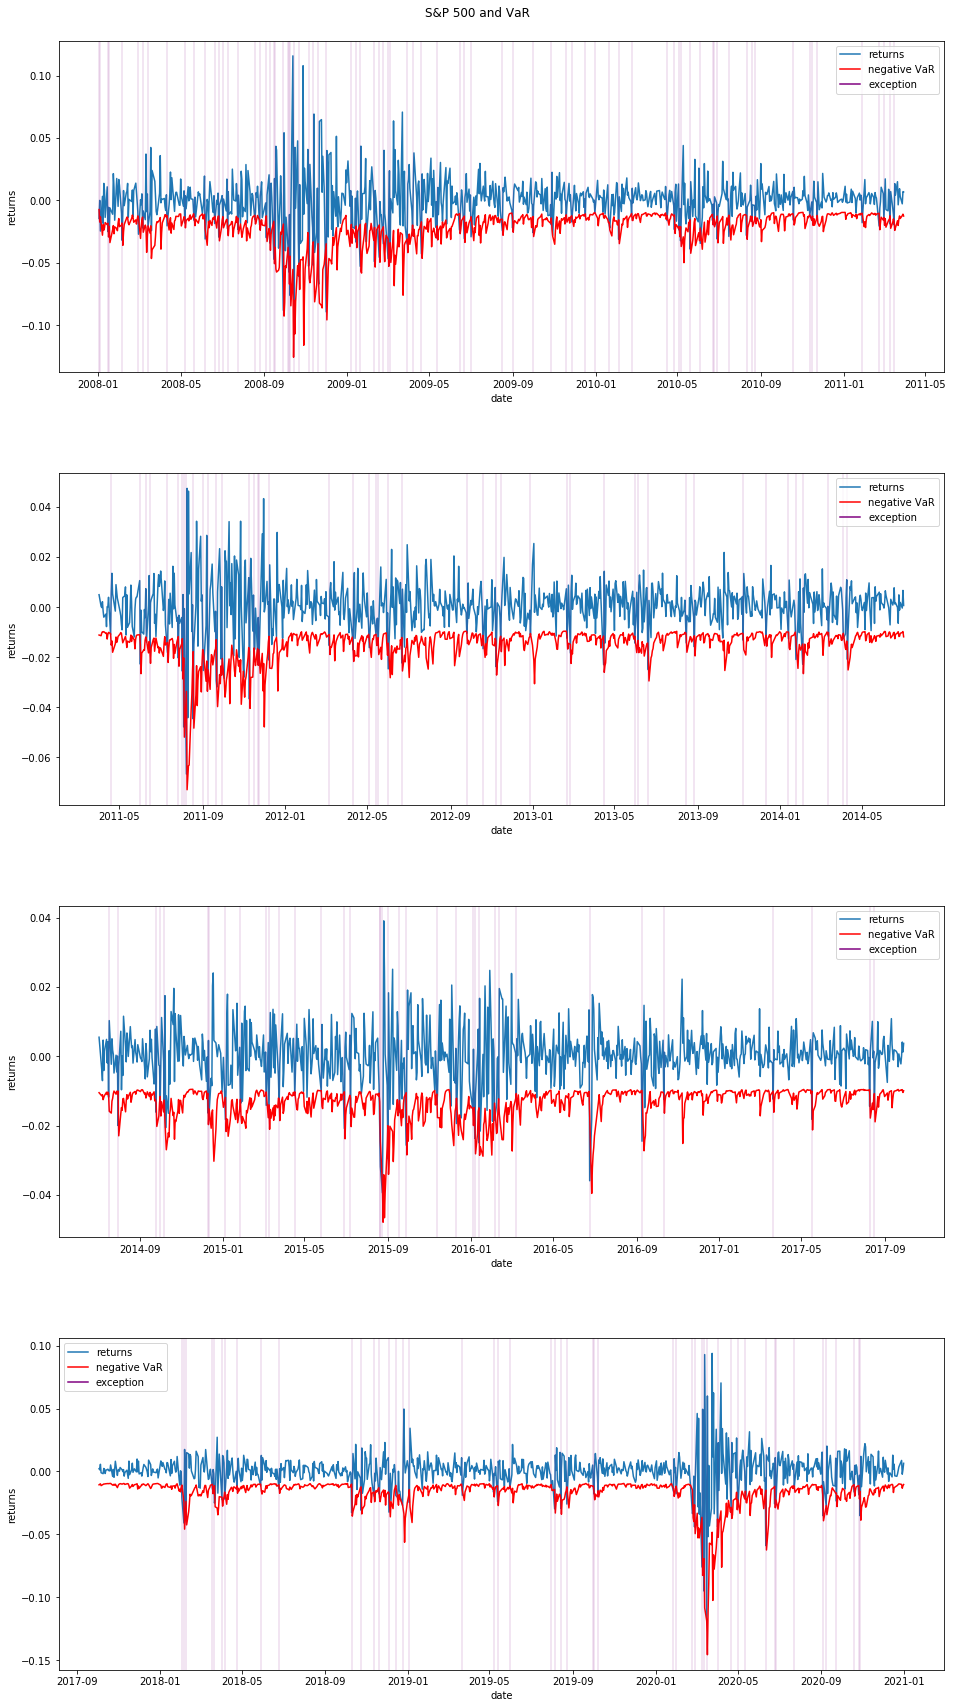

In [7]:
# Number of rows
k = 4

# Plot returns
n = len(sp500)/k

fig, ax = plt.subplots(k, 1, figsize = (15,25))

for i in range(k):

    ax[i].plot(sp500.loc[(i * n):(i * n + n - 1), 'Date'], sp500.loc[(i * n):(i * n + n - 1), 'Ret'], label = 'returns')
    ax[i].plot(sp500.loc[(i * n):(i * n + n - 1), 'Date'], 0 - sp500.loc[(i * n):(i * n + n - 1), 'VaR'], color = 'red', 
               label = 'negative VaR')
    ax[i].plot([], [], label = "exception", color = 'purple')
    ax[i].set_xlabel('date') 
    ax[i].set_ylabel('returns') 
    ax[i].legend()
    
    for j in range(int(i * n), int(i * n + n)):

        if sp500.loc[j, 'exception'] == True:
            
            ax[i].axvline(x = sp500.loc[j, 'Date'], color = 'purple', linewidth = 0.2)
            
fig.suptitle('S&P 500 and VaR')
plt.tight_layout(pad = 7)

plt.show()


In [17]:
sp500.to_csv('GARCH_VaR_SP500.csv', index = False)

sp500.head()

,Date,Ret,VaR,Exception,Frac_Excp
0,2008-01-02,-0.014438,0.007356,True,0.130435
1,2008-01-03,0.000000,0.017359,False,0.130435
2,2008-01-04,-0.024552,0.013215,True,0.130435
3,2008-01-07,0.003223,0.027862,False,0.130435
4,2008-01-08,-0.018352,0.019388,False,0.130435
